#GROWING CENTROID-POSSE PLOT

Damon Crockett, Software Studies Initiative, Qualcomm Institute, UCSD

##CENTROID DATA

In [1]:
DIR = "/Users/damoncrockett/Desktop/cities_20k/yahoo/NEW_Clusters/Clusters_Normalized/"

In [2]:
DATA = DIR+"Normalized_Clustered/50/cluster_characterization_general_concepts_abstract_ideas.csv"

In [3]:
import pandas as pd
df = pd.read_csv(DATA)
del df['Unnamed: 0']

##PCA

In [4]:
# note: PCA works MUCH better than t-SNE for this purpose

In [5]:
from sklearn.decomposition import RandomizedPCA as pca
pca = pca(n_components=2)
X = df.as_matrix()
pca.fit(X)
subspace = pd.DataFrame(pca.transform(X),columns=["x","y"])

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

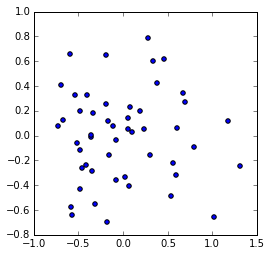

In [7]:
x = subspace.x
y = subspace.y
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(x, y)

##IMAGE DATA

In [8]:
BASE = "/Users/damoncrockett/Desktop/cities_20k/"

In [9]:
import os
import glob

####ADD LOCAL PATHS

In [10]:
for file in glob.glob(os.path.join(BASE+"yahoo/","*.tsv")):
    tmp = pd.read_csv(file)
    n = len(tmp.index)
    local_path = []
    for i in range(n):
        local_path.append(BASE+os.path.basename(file).split("_")[0]+"_20k/"+tmp.ad_id.loc[i]+".jpg")
    tmp['local_path'] = local_path
    tmp.to_csv(file,index=False)

####SUBSET TO COLUMNS IN CLUSTER CATEGORY

In [11]:
counter=-1

for file in glob.glob(os.path.join(BASE+"yahoo/","*.tsv")):
    counter+=1
    tmp = pd.read_csv(file)
    columns = list(df.columns.values)
    columns.append("ad_id")
    columns.append("local_path")
    tmp = tmp[columns]
    if counter==0:
        collection = tmp
    else:
        collection = collection.append(tmp)

In [12]:
collection.dropna(inplace=True)

####ADD CLUSTER LABELS

In [13]:
label_df = pd.read_csv(DIR+"Normalized_Cluster_Labels/50/general_concepts_abstract_ideas.csv")
label_df.rename(columns={"image_id":"ad_id"},inplace=True)
label_df = label_df[["ad_id","cluster_id"]]
label_df.set_index("ad_id",inplace=True)

In [14]:
collection = collection.join(label_df,on="ad_id")

In [15]:
collection = collection[collection.cluster_id.notnull()]

In [16]:
collection.reset_index(drop=True,inplace=True)

####EUCLIDEAN DISTANCE FROM CENTROID

In [17]:
import numpy as np

In [18]:
euclidean_distance = []

n = len(collection.index)
for i in range(n):
    tmp = collection.iloc[i].as_matrix()
    cluster_integer = int(collection.cluster_id.loc[i])
    m = len(tmp) - 3
    tmp = tmp[:m]
    
    # note: df is zero-indexed but cluster labels are 1-indexed
    euclidean_distance_i = np.linalg.norm(tmp - df.iloc[cluster_integer - 1].as_matrix())
    euclidean_distance.append(euclidean_distance_i)

In [19]:
collection['euclidean_distance'] = euclidean_distance

In [20]:
collection = collection[['local_path','cluster_id','euclidean_distance']]

##GRID

In [21]:
num_bins = 100

In [22]:
# adding in some extremes to push the edges out

print subspace.x.min(), subspace.x.max(), subspace.y.min(), subspace.y.max()

-0.723903349816 1.30560190587 -0.699547777813 0.789275482636


In [23]:
x = [-1,1.5]
y = [-1,1]

tmp = pd.DataFrame(x,columns=["x"])
tmp["y"] = y
subspace = subspace.append(tmp)

In [24]:
subspace['x_bin'] = pd.cut(subspace['x'],num_bins,labels=False)
subspace['y_bin'] = pd.cut(subspace['y'],num_bins,labels=False)

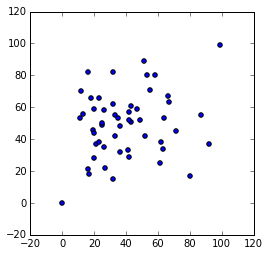

In [25]:
x = subspace.x_bin
y = subspace.y_bin
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(x, y)

In [26]:
# now we can remove the extreme points we used as grid expanders

subspace = subspace[:50]

In [27]:
# now to expand the grid by simple multiplication

subspace["x_grid"] = subspace.x_bin * 4
subspace["y_grid"] = subspace.y_bin * 4

In [28]:
from shapely.geometry import Point

centroid_point = []
n = len(subspace.index)
for i in range(n):
    centroid_point.append(Point(subspace.x_grid.loc[i],subspace.y_grid.loc[i]))
    
subspace['centroid_point'] = centroid_point

####GRID LIST

In [29]:
x,y = range(400) * 400, np.repeat(range(400),400)
grid_list = pd.DataFrame(x,columns=['x'])
grid_list['y'] = y

In [30]:
point = []
n = len(grid_list.index)
for i in range(n):
    point.append(Point(grid_list.x.loc[i],grid_list.y.loc[i]))

grid_list['point'] = point

In [31]:
open_grid = list(grid_list.point)

In [32]:
centroids = list(subspace.centroid_point)

####REMOVAL OF CENTROIDS FROM OPEN_GRID LIST

In [33]:
len(open_grid)

160000

In [34]:
len(centroids)

50

In [35]:
# note that this will have the effect that, in the plot, the centroid locations will be empty

In [36]:
open_grid = [item for item in open_grid if item not in centroids]

In [37]:
len(open_grid)

159950

##PLOT FUNCTION

In [38]:
from PIL import Image

In [39]:
thumb_side = 64

In [40]:
px_w = thumb_side * 400
px_h = thumb_side * 400

In [41]:
canvas = Image.new('RGB',(px_w,px_h),(50,50,50))

In [44]:
def plot():
    n = len(subspace.index)
    for i in range(n):
        centroid = subspace.centroid_point.loc[i]
        try:
            # again, a workaround for indexing difference
            candidates = collection[collection.cluster_id==i+1]
            candidates.sort("euclidean_distance",inplace=True)
            best = candidates.iloc[0]
            im = Image.open(best.local_path)
            im.thumbnail((thumb_side,thumb_side),Image.ANTIALIAS)
            closest_open = min(open_grid,key=lambda x: centroid.distance(x))
            x = int(closest_open.x) * thumb_side
            y = int(closest_open.y) * thumb_side
            canvas.paste(im,(x,y))
            idx = collection[collection.local_path==best.local_path].index
            collection.drop(idx,inplace=True)
            open_grid.remove(closest_open)
            print i
        except:
            print "cluster empty"

In [45]:
for i in range(64):
    print "plot_",i
    plot()

plot_ 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
plot_ 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
plot_ 2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
plot_ 3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
plot_ 4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
plot_ 5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
plot_ 6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


/Library/Python/2.7/site-packages/pandas/core/frame.py:2915: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  inplace=inplace, kind=kind, na_position=na_position)


In [46]:
canvas.show()

In [48]:
canvas.save("/Users/damoncrockett/Desktop/posse.png")

In [49]:
for i in range(192):
    print "plot_",i
    plot()

plot_ 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
cluster empty
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
plot_ 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
cluster empty
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
plot_ 2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
cluster empty
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
plot_ 3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
cluster empty
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
plot_ 4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
cluster empty
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
plot_ 5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
cluster empty
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
plot_ 6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [51]:
canvas.save("/Users/damoncrockett/Desktop/posse_256.png")

In [52]:
for i in range(256):
    print "plot_",i
    plot()

plot_ 0
0
cluster empty
2
3
4
5
cluster empty
7
8
9
10
11
12
13
14
15
16
17
18
cluster empty
20
21
22
23
24
25
cluster empty
27
28
cluster empty
30
31
32
33
34
35
36
cluster empty
38
39
40
cluster empty
42
43
44
cluster empty
46
47
48
49
plot_ 1
0
cluster empty
2
3
4
5
cluster empty
7
8
9
10
11
12
13
14
15
16
17
18
cluster empty
20
21
22
23
24
25
cluster empty
27
28
cluster empty
30
31
32
33
34
35
36
cluster empty
38
39
40
cluster empty
42
43
44
cluster empty
46
47
48
49
plot_ 2
0
cluster empty
2
3
4
5
cluster empty
7
8
9
10
11
12
13
14
15
16
17
18
cluster empty
20
21
22
23
24
25
cluster empty
27
28
cluster empty
30
31
32
33
34
35
36
cluster empty
38
39
40
cluster empty
42
43
44
cluster empty
46
47
48
49
plot_ 3
0
cluster empty
2
3
4
5
cluster empty
7
8
9
10
11
12
13
14
15
16
17
18
cluster empty
20
21
22
23
24
25
cluster empty
27
28
cluster empty
30
31
32
33
34
35
36
cluster empty
38
39
40
cluster empty
42
43
44
cluster empty
46
47
48
49
plot_ 4
0
cluster empty
2
3
4
5
cluster empty
7


In [53]:
canvas.save("/Users/damoncrockett/Desktop/posse_512.png")